# 연합학습 결과 시각화 분석

이 노트북에서는 연합학습 실험 결과의 정확도(Accuracy), AUC, F1 값을 다양한 그래프로 시각화하여 분석합니다.

## 1. 라이브러리 Import 및 데이터 로드

필요한 라이브러리를 import하고 텍스트 파일에서 데이터를 읽어옵니다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 스타일 설정
#sns.set_style("whitegrid")
plt.style.use('default')  # 기본 스타일 사용

plt.rcParams['figure.figsize'] = (12, 8)

In [6]:
# 데이터 파일 로드
file_path = '/home/nakhoon/federated_cifar10/1027_0651_v2.7_R50_[csf1.5,ew0.3]/federated_learning_results_v2.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    content = file.read()

print("데이터 파일이 성공적으로 로드되었습니다.")
print(f"파일 크기: {len(content)} 문자")

데이터 파일이 성공적으로 로드되었습니다.
파일 크기: 24006 문자


## 2. 데이터 전처리 및 구조화

텍스트 파일의 각 섹션을 파싱하여 pandas DataFrame으로 변환합니다.

In [7]:
def parse_performance_data(content):
    """라운드별 글로벌 모델 성능 데이터 파싱"""
    lines = content.split('\n')
    performance_start = False
    performance_data = []
    
    for line in lines:
        if '라운드별 글로벌 모델 성능' in line:
            performance_start = True
            continue
        elif performance_start and line.strip() == '':
            break
        elif performance_start and line.strip() and not line.startswith('=') and not line.startswith('Round'):
            if line.strip().split()[0].isdigit():
                parts = line.strip().split()
                round_num = int(parts[0])
                accuracy = float(parts[1])
                f1 = float(parts[2])
                auc = float(parts[3])
                performance_data.append({
                    'Round': round_num,
                    'Overall_Accuracy': accuracy,
                    'Overall_F1': f1,
                    'Overall_AUC': auc
                })
    
    return pd.DataFrame(performance_data)

def parse_client_data(content):
    """클라이언트 데이터 분할 현황 파싱"""
    lines = content.split('\n')
    client_start = False
    client_data = []
    
    for line in lines:
        if '데이터 분할 현황' in line:
            client_start = True
            continue
        elif client_start and line.strip() == '':
            break
        elif client_start and line.strip() and not line.startswith('=') and not line.startswith('Client'):
            if line.strip().split()[0].isdigit():
                parts = line.strip().split()
                client_id = int(parts[0])
                num_samples = int(parts[1])
                classes = [int(x) for x in parts[2:12]]
                
                data_row = {'Client': client_id, 'Num_Samples': num_samples}
                for i, count in enumerate(classes):
                    data_row[f'Class_{i}'] = count
                client_data.append(data_row)
    
    return pd.DataFrame(client_data)

def parse_weights_data(content):
    """라운드별 모델 합성 가중치 파싱"""
    lines = content.split('\n')
    weights_start = False
    weights_data = []
    
    for line in lines:
        if '라운드별 모델 합성 가중치' in line:
            weights_start = True
            continue
        elif weights_start and line.strip() == '':
            break
        elif weights_start and line.strip() and not line.startswith('=') and not line.startswith('Round'):
            if line.startswith('Round'):
                parts = line.strip().split()
                round_num = int(parts[1])
                weights = [float(x) for x in parts[2:12]]
                
                data_row = {'Round': round_num}
                for i, weight in enumerate(weights):
                    data_row[f'Client_{i}_Weight'] = weight
                weights_data.append(data_row)
    
    return pd.DataFrame(weights_data)

# 데이터 파싱
performance_df = parse_performance_data(content)
client_df = parse_client_data(content)
weights_df = parse_weights_data(content)

print("데이터 파싱 완료!")
print(f"성능 데이터: {len(performance_df)} 라운드")
print(f"클라이언트 데이터: {len(client_df)} 클라이언트")
print(f"가중치 데이터: {len(weights_df)} 라운드")

데이터 파싱 완료!
성능 데이터: 50 라운드
클라이언트 데이터: 10 클라이언트
가중치 데이터: 0 라운드


In [8]:
# 데이터 미리보기
print("성능 데이터 미리보기:")
print(performance_df.head())
print("\n클라이언트 데이터 미리보기:")
print(client_df.head())

성능 데이터 미리보기:
   Round  Overall_Accuracy  Overall_F1  Overall_AUC
0      1            0.1499      0.0663       0.7421
1      2            0.4479      0.4462       0.8922
2      3            0.5942      0.5914       0.9326
3      4            0.6632      0.6630       0.9492
4      5            0.7008      0.7010       0.9581

클라이언트 데이터 미리보기:
   Client  Num_Samples  Class_0  Class_1  Class_2  Class_3  Class_4  Class_5  \
0       0            0     3847      107      886      649      195      364   
1       1            1     3575      454      100      263      839      337   
2       2            2     5709     1131      102      484      537      627   
3       3            3     6301      216     1611      101      123      495   
4       4            4     7718      717      395      732      240     1916   

   Class_6  Class_7  Class_8  Class_9  
0      377      299      428      111  
1      491      104      509      370  
2      244      122      235     2051  
3      967      6

## 3. 라운드별 성능 지표 시계열 그래프

라운드별 Accuracy, F1, AUC 값의 변화를 시계열 그래프로 시각화합니다.

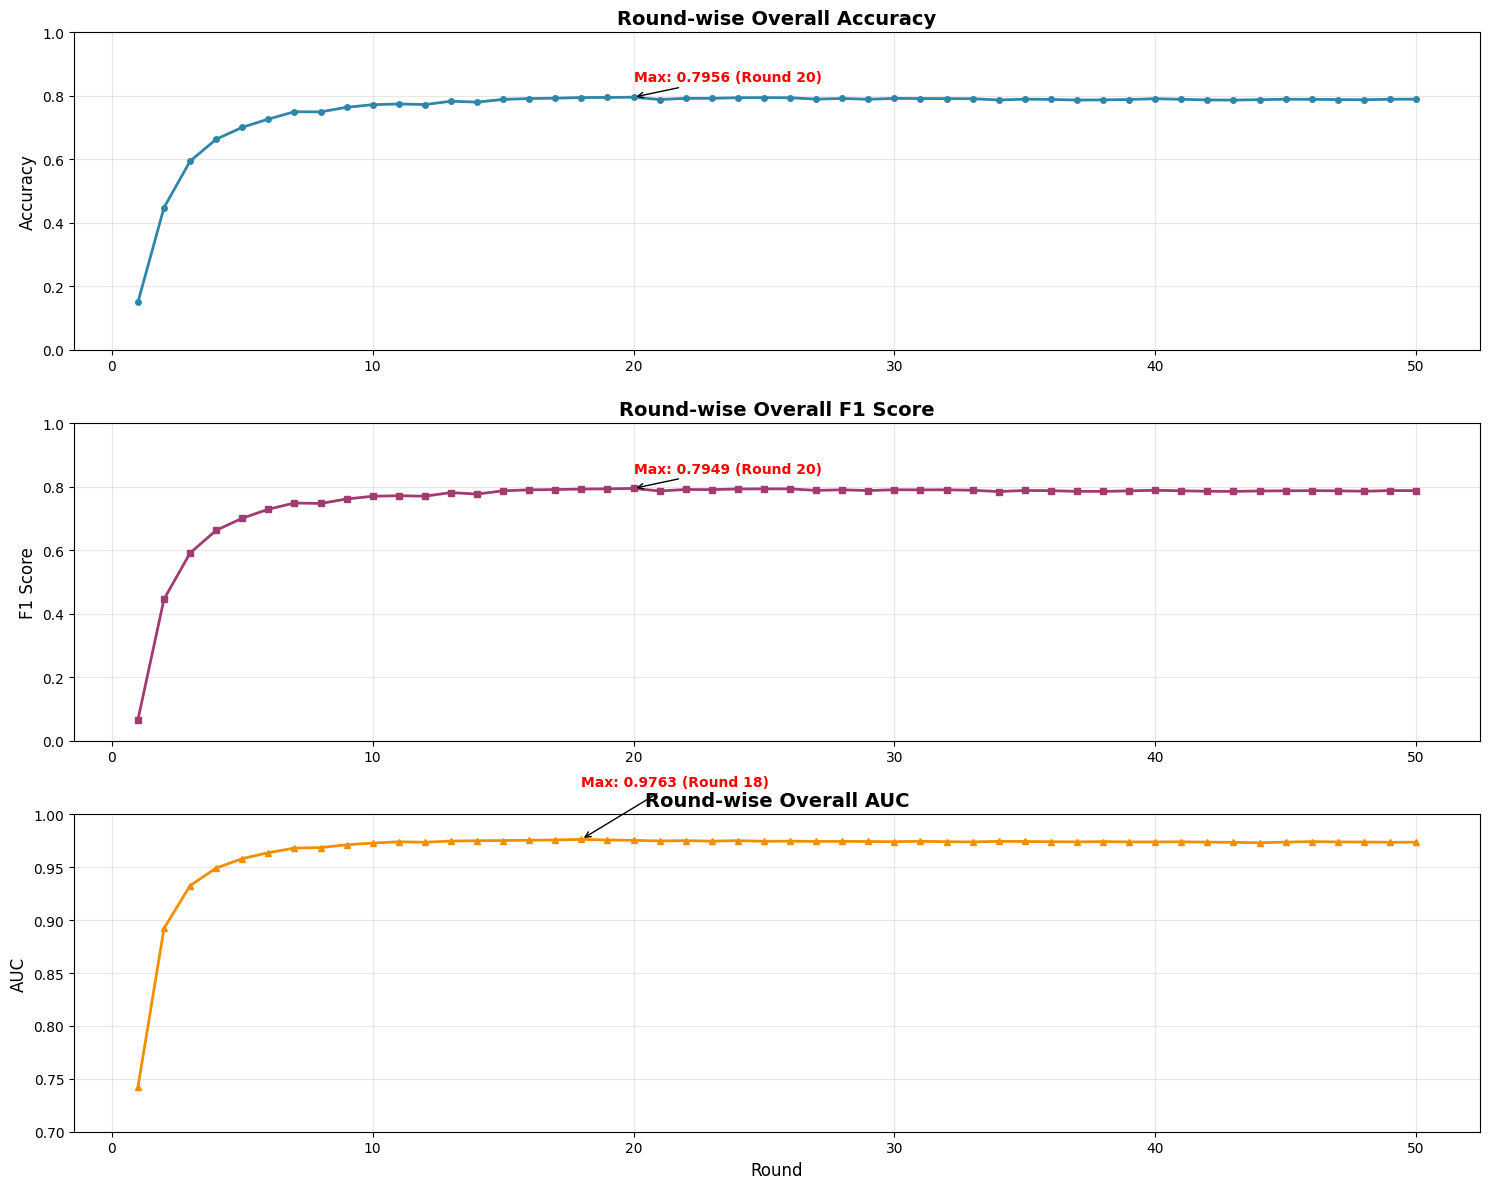

성능 지표 통계:
       Overall_Accuracy  Overall_F1  Overall_AUC
count         50.000000   50.000000    50.000000
mean           0.757548    0.754666     0.965876
std            0.105529    0.115407     0.034980
min            0.149900    0.066300     0.742100
25%            0.780875    0.778200     0.973600
50%            0.788700    0.787350     0.974050
75%            0.791300    0.790375     0.974575
max            0.795600    0.794900     0.976300


In [11]:
# 라운드별 성능 지표 시계열 그래프
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Accuracy 그래프
axes[0].plot(performance_df['Round'], performance_df['Overall_Accuracy'], 
             marker='o', linewidth=2, markersize=4, color='#2E86AB')
axes[0].set_title('Round-wise Overall Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

# F1 Score 그래프
axes[1].plot(performance_df['Round'], performance_df['Overall_F1'], 
             marker='s', linewidth=2, markersize=4, color='#A23B72')
axes[1].set_title('Round-wise Overall F1 Score', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

# AUC 그래프
axes[2].plot(performance_df['Round'], performance_df['Overall_AUC'], 
             marker='^', linewidth=2, markersize=4, color='#F18F01')
axes[2].set_title('Round-wise Overall AUC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Round', fontsize=12)
axes[2].set_ylabel('AUC', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(0.7, 1)

# 각 그래프에 최고 값을 표기해줘
for ax, metric in zip(axes, ['Overall_Accuracy', 'Overall_F1', 'Overall_AUC']):
    max_idx = performance_df[metric].idxmax()
    max_round = performance_df.loc[max_idx, 'Round']
    max_value = performance_df.loc[max_idx, metric]
    ax.annotate(f'Max: {max_value:.4f} (Round {max_round})',
                xy=(max_round, max_value),
                xytext=(max_round, max_value + 0.05),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                fontsize=10, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# 성능 지표 통계 정보
print("성능 지표 통계:")
print(performance_df[['Overall_Accuracy', 'Overall_F1', 'Overall_AUC']].describe())

## 4. 성능 지표 비교 그래프

Accuracy, F1, AUC 세 지표를 하나의 그래프에서 비교 분석합니다.

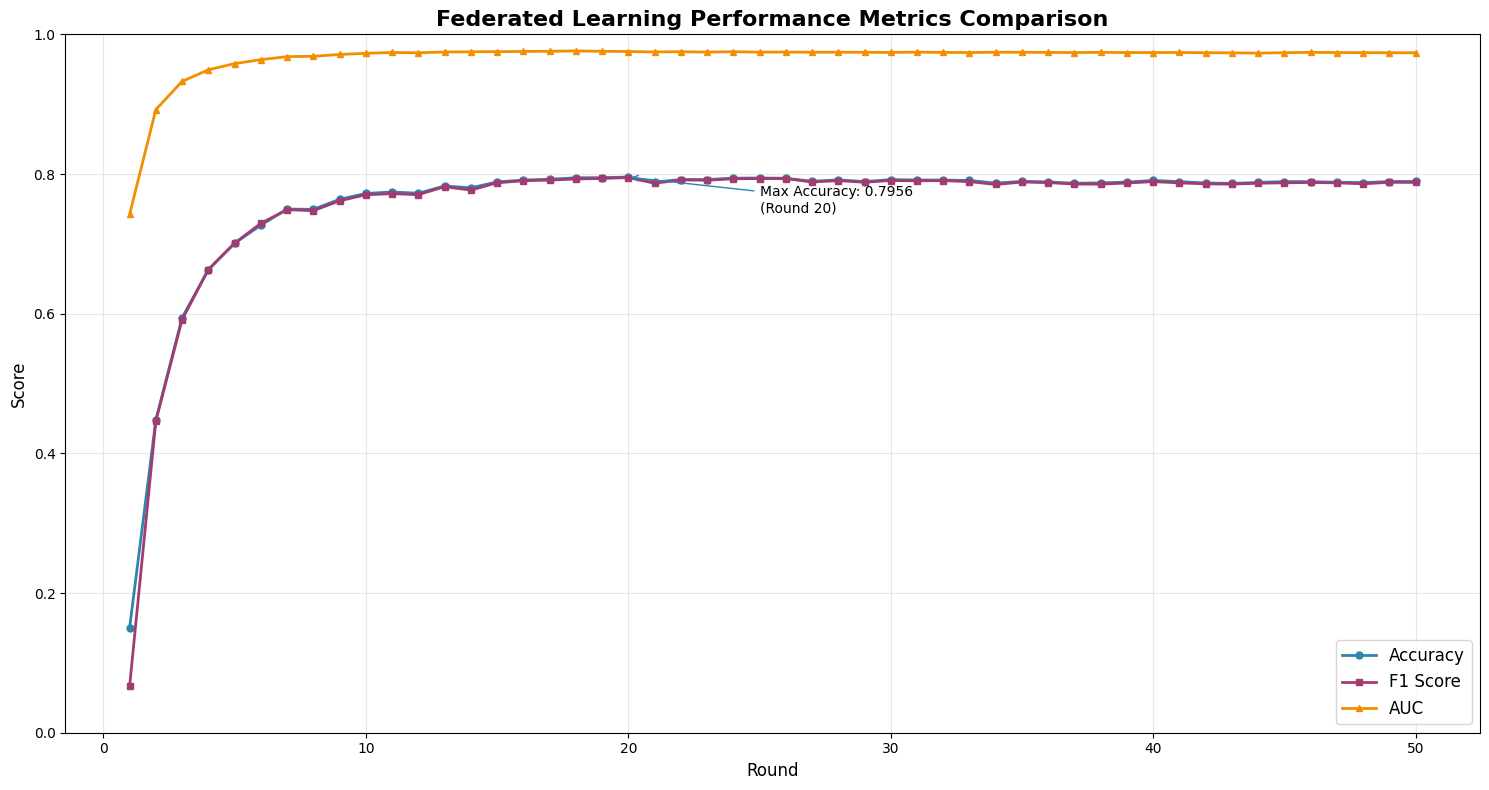

In [10]:
# 모든 성능 지표를 하나의 그래프에서 비교
plt.figure(figsize=(15, 8))

plt.plot(performance_df['Round'], performance_df['Overall_Accuracy'], 
         marker='o', linewidth=2, markersize=5, label='Accuracy', color='#2E86AB')
plt.plot(performance_df['Round'], performance_df['Overall_F1'], 
         marker='s', linewidth=2, markersize=5, label='F1 Score', color='#A23B72')
plt.plot(performance_df['Round'], performance_df['Overall_AUC'], 
         marker='^', linewidth=2, markersize=5, label='AUC', color='#F18F01')

plt.title('Federated Learning Performance Metrics Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Round', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# 주요 이정표 표시
max_acc_round = performance_df.loc[performance_df['Overall_Accuracy'].idxmax(), 'Round']
max_acc_value = performance_df['Overall_Accuracy'].max()
plt.annotate(f'Max Accuracy: {max_acc_value:.4f}\n(Round {max_acc_round})', 
             xy=(max_acc_round, max_acc_value), xytext=(max_acc_round+5, max_acc_value-0.05),
             arrowprops=dict(arrowstyle='->', color='#2E86AB'), fontsize=10)

plt.tight_layout()
plt.show()

In [12]:
# 성능 지표 간 상관관계 분석
correlation_matrix = performance_df[['Overall_Accuracy', 'Overall_F1', 'Overall_AUC']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, fmt='.4f', cbar_kws={'shrink': 0.8})
plt.title('Performance Metrics Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("성능 지표 간 상관관계:")
print(correlation_matrix)

NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>

## 5. 수렴성 분석 시각화

성능 지표의 변화율과 이동평균을 계산하여 모델의 수렴성을 분석합니다.


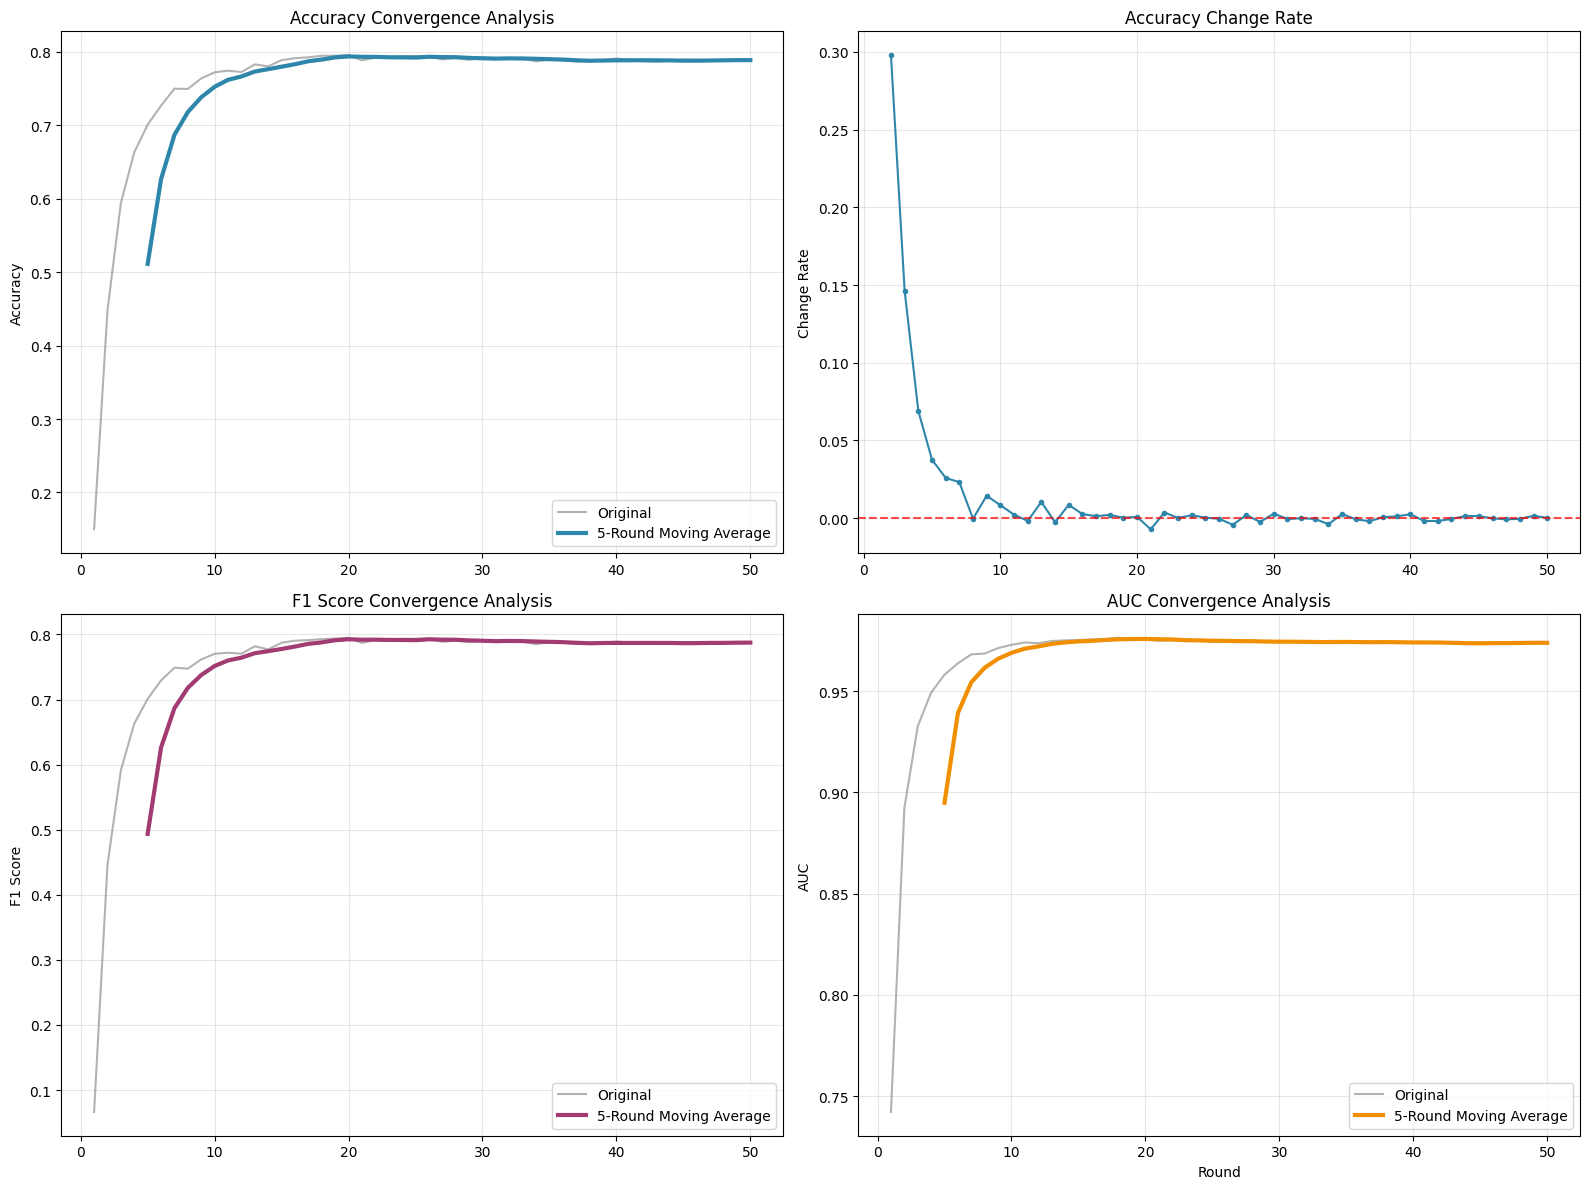

성능 개선이 미미해지는 라운드 분석:
최근 10라운드 평균 정확도 변화: -0.000150
최근 10라운드 평균 F1 변화: -0.000110
최근 10라운드 평균 AUC 변화: -0.000030

각 그래프의 최고값:
최고 정확도: 0.795600 (라운드 20)
최고 F1 점수: 0.794900 (라운드 20)
최고 AUC 점수: 0.976300 (라운드 18)


In [ ]:
# 변화율 계산
performance_df['Accuracy_Change'] = performance_df['Overall_Accuracy'].diff()
performance_df['F1_Change'] = performance_df['Overall_F1'].diff()
performance_df['AUC_Change'] = performance_df['Overall_AUC'].diff()

# 이동평균 계산 (윈도우 크기 5)
window_size = 5
performance_df['Accuracy_MA'] = performance_df['Overall_Accuracy'].rolling(window=window_size).mean()
performance_df['F1_MA'] = performance_df['Overall_F1'].rolling(window=window_size).mean()
performance_df['AUC_MA'] = performance_df['Overall_AUC'].rolling(window=window_size).mean()

# 수렴성 분석 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


# 원본 데이터와 이동평균
axes[0, 0].plot(performance_df['Round'], performance_df['Overall_Accuracy'], 
                alpha=0.6, label='Original', color='grey')
axes[0, 0].plot(performance_df['Round'], performance_df['Accuracy_MA'], 
                linewidth=3, label=f'{window_size}-Round Moving Average', color='#2E86AB')
axes[0, 0].set_title('Accuracy Convergence Analysis', fontsize=12)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 변화율 그래프
axes[0, 1].plot(performance_df['Round'][1:], performance_df['Accuracy_Change'][1:], 
                marker='o', markersize=3, color='#2E86AB')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0, 1].set_title('Accuracy Change Rate', fontsize=12)
axes[0, 1].set_ylabel('Change Rate')
axes[0, 1].grid(True, alpha=0.3)

# F1 Score 이동평균
axes[1, 0].plot(performance_df['Round'], performance_df['Overall_F1'], 
                alpha=0.6, label='Original', color='grey')
axes[1, 0].plot(performance_df['Round'], performance_df['F1_MA'], 
                linewidth=3, label=f'{window_size}-Round Moving Average', color='#A23B72')
axes[1, 0].set_title('F1 Score Convergence Analysis', fontsize=12)
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# AUC 그래프 , Original 그래프의 색은 진하게 
axes[1, 1].plot(performance_df['Round'], performance_df['Overall_AUC'], 
                alpha=0.6, label='Original', color='grey')
axes[1, 1].plot(performance_df['Round'], performance_df['AUC_MA'], 
                linewidth=3, label=f'{window_size}-Round Moving Average', color='#F18F01')
axes[1, 1].set_title('AUC Convergence Analysis', fontsize=12)
axes[1, 1].set_xlabel('Round')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 수렴 지점 분석
print("성능 개선이 미미해지는 라운드 분석:")
recent_rounds = performance_df.tail(10)
# 아래 값은 최근 10라운드의 평균 변화량입니다
# 예: 최근 10라운드 평균 정확도 변화: -0.00015 라면, 이 뜻은 최근 10라운드 동안 정확도가 평균적으로 0.00015씩 감소했다는 의미입니다.
print(f"최근 10라운드 평균 정확도 변화: {recent_rounds['Accuracy_Change'].mean():.6f}")
print(f"최근 10라운드 평균 F1 변화: {recent_rounds['F1_Change'].mean():.6f}")
print(f"최근 10라운드 평균 AUC 변화: {recent_rounds['AUC_Change'].mean():.6f}")

# 각 그래프의 최고값: 
print("\n각 그래프의 최고값:")
max_acc_idx = performance_df['Overall_Accuracy'].idxmax()
max_f1_idx = performance_df['Overall_F1'].idxmax()
max_auc_idx = performance_df['Overall_AUC'].idxmax()
print(f"최고 정확도: {performance_df.loc[max_acc_idx, 'Overall_Accuracy']:.6f} (라운드 {performance_df.loc[max_acc_idx, 'Round']})")
print(f"최고 F1 점수: {performance_df.loc[max_f1_idx, 'Overall_F1']:.6f} (라운드 {performance_df.loc[max_f1_idx, 'Round']})")
print(f"최고 AUC 점수: {performance_df.loc[max_auc_idx, 'Overall_AUC']:.6f} (라운드 {performance_df.loc[max_auc_idx, 'Round']})")

# 각 그래프 Accuracy Convergence Analysis, F1 Score Convergence Analysis, Accuracy Change Rate, AUC Convergence Analysis에 대해 각각 자세하게 3줄이상으로 설명하면, 다음과 같습니다. 
# 1. Accuracy Convergence Analysis:
#    - 이 그래프는 라운드별로 측정된 정확도(Accuracy)를 나타내며, 원본 데이터와 이동평균선을 함께 보여줍니다.
#    - 이동평균선은 최근 5라운드의 평균 정확도를 나타내어, 전체적인 추세를 파악하는 데 도움을 줍니다.
#    - 그래프를 통해 정확도가 시간이 지남에 따라 어떻게 변화하는지, 그리고 수렴하는 경향이 있는지를 시각적으로 확인할 수 있습니다.
# 2. F1 Score Convergence Analysis:
#    - 이 그래프는 라운드별로 측정된 F1 점수를 나타내며, 원본 데이터와 이동평균선을 함께 보여줍니다.    
#    - 이동평균선은 최근 5라운드의 평균 F1 점수를 나타내어, 전체적인 추세를 파악하는 데 도움을 줍니다.
#    - 그래프를 통해 F1 점수가 시간이 지남에 따라 어떻게 변화하는지, 그리고 수렴하는 경향이 있는지를 시각적으로 확인할 수 있습니다.
# 3. Accuracy Change Rate:
#    - 이 그래프는 라운드별로 정확도의 변화율을 나타냅니다.
#    - 변화율이 0에 가까워질수록 모델의 성능이 안정화되고 있음을 의미합니다.
#    - 그래프를 통해 어느 시점에서 성능 개선이 미미해지는지를 파악할 수 있습니다.
# 4. AUC Convergence Analysis:
#    - 이 그래프는 라운드별로 측정된 AUC 점수를 나타내며, 원본 데이터와 이동평균선을 함께 보여줍니다.
#    - 이동평균선은 최근 5라운드의 평균 AUC 점수를 나타내어, 전체적인 추세를 파악하는 데 도움을 줍니다.
#    - 그래프를 통해 AUC 점수가 시간이 지남에 따라 어떻게 변화하는지, 그리고 수렴하는 경향이 있는지를 시각적으로 확인할 수 있습니다.

## 6. 클라이언트 데이터 분포 시각화

각 클라이언트의 클래스별 데이터 분포를 히트맵과 막대그래프로 시각화합니다.

In [14]:
# 클라이언트별 클래스 분포 히트맵
class_columns = [f'Class_{i}' for i in range(10)]
class_data = client_df[class_columns].values

plt.figure(figsize=(12, 8))
sns.heatmap(class_data, 
            xticklabels=[f'Class {i}' for i in range(10)],
            yticklabels=[f'Client {i}' for i in range(len(client_df))],
            annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Number of Samples'})
plt.title('Data Distribution Across Clients and Classes', fontsize=14, fontweight='bold')
plt.xlabel('Classes')
plt.ylabel('Clients')
plt.tight_layout()
plt.show()

# 클라이언트별 총 샘플 수
plt.figure(figsize=(12, 6))
bars = plt.bar(client_df['Client'], client_df['Num_Samples'], 
               color=plt.cm.Set3(np.linspace(0, 1, len(client_df))))
plt.title('Total Samples per Client', fontsize=14, fontweight='bold')
plt.xlabel('Client ID')
plt.ylabel('Number of Samples')
plt.grid(True, alpha=0.3, axis='y')

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("클라이언트별 데이터 분포 통계:")
print(client_df[['Client', 'Num_Samples']].describe())

NameError: name 'sns' is not defined

<Figure size 1200x800 with 0 Axes>

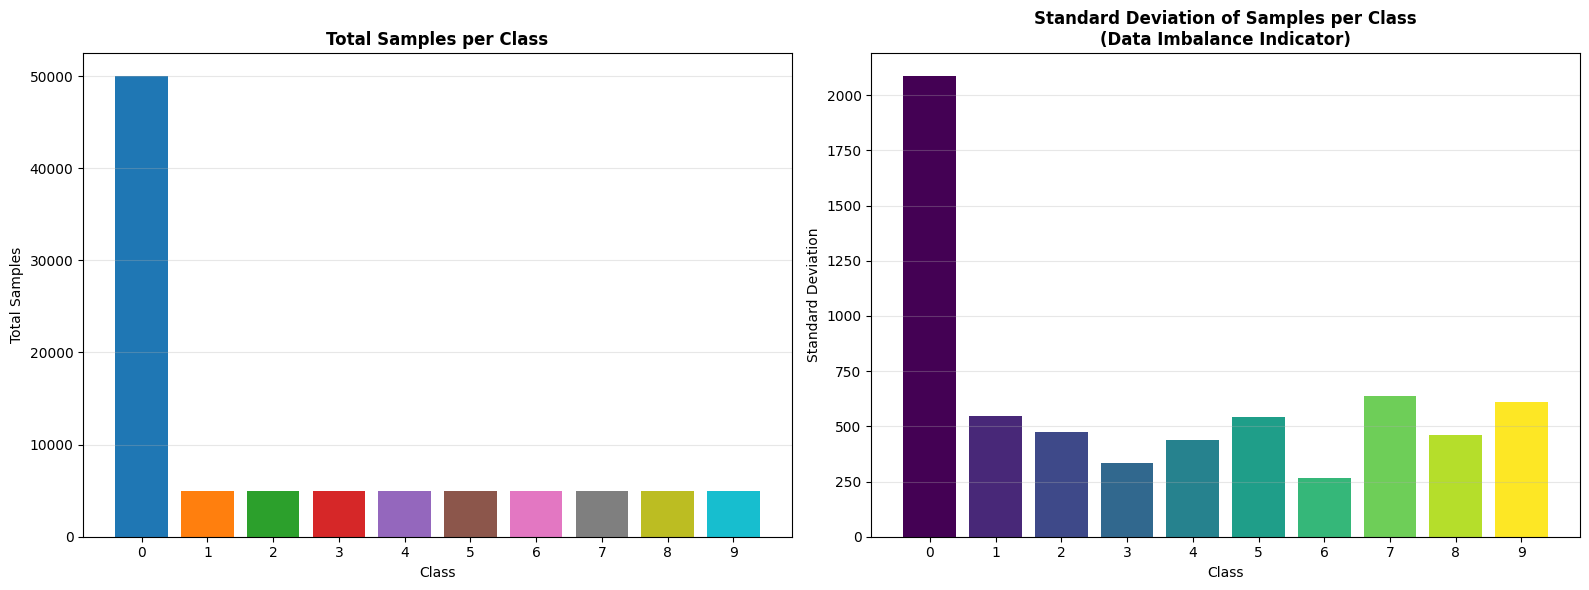

클래스별 분포 불균형 분석:
         Class  Total_Samples  Std_Deviation  Coefficient_of_Variation
Class_0      0          50000    2086.236164                  0.041725
Class_1      1           5000     548.032237                  0.109606
Class_2      2           5000     475.295230                  0.095059
Class_3      3           5000     335.101643                  0.067020
Class_4      4           5000     437.640644                  0.087528
Class_5      5           5000     542.563668                  0.108513
Class_6      6           5000     267.535667                  0.053507
Class_7      7           5000     635.559246                  0.127112
Class_8      8           5000     460.857896                  0.092172
Class_9      9           5000     609.538259                  0.121908


In [15]:
# 데이터 불균형 분석
class_totals = client_df[class_columns].sum()
class_std = client_df[class_columns].std()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 클래스별 총 샘플 수
axes[0].bar(range(10), class_totals, color=plt.cm.tab10(np.linspace(0, 1, 10)))
axes[0].set_title('Total Samples per Class', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Total Samples')
axes[0].set_xticks(range(10))
axes[0].grid(True, alpha=0.3, axis='y')

# 클래스별 표준편차 (불균형 정도)
axes[1].bar(range(10), class_std, color=plt.cm.viridis(np.linspace(0, 1, 10)))
axes[1].set_title('Standard Deviation of Samples per Class\n(Data Imbalance Indicator)', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_xticks(range(10))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("클래스별 분포 불균형 분석:")
imbalance_df = pd.DataFrame({
    'Class': range(10),
    'Total_Samples': class_totals,
    'Std_Deviation': class_std,
    'Coefficient_of_Variation': class_std / class_totals
})
print(imbalance_df)

## 7. 가중치 변화 추이 그래프

라운드별 클라이언트 가중치 변화를 선 그래프로 시각화하여 각 클라이언트의 기여도 변화 패턴을 분석합니다.

In [16]:
# 가중치 데이터가 비어있을 경우를 대비한 더미 데이터 생성
if weights_df.empty:
    print("가중치 데이터를 다시 파싱합니다...")
    # 직접 텍스트에서 가중치 데이터 추출
    weight_lines = []
    lines = content.split('\n')
    in_weight_section = False
    
    for line in lines:
        if '라운드별 모델 합성 가중치' in line:
            in_weight_section = True
            continue
        elif in_weight_section and '라운드별 시간 측정' in line:
            break
        elif in_weight_section and line.strip() and not line.startswith('='):
            if line.strip().split()[0].startswith('Round'):
                weight_lines.append(line.strip())
    
    # 가중치 데이터 파싱
    weights_data = []
    for line in weight_lines:
        parts = line.split()
        if len(parts) >= 11:
            round_num = int(parts[1])
            weights = [float(x) for x in parts[2:12]]
            
            data_row = {'Round': round_num}
            for i, weight in enumerate(weights):
                data_row[f'Client_{i}_Weight'] = weight
            weights_data.append(data_row)
    
    weights_df = pd.DataFrame(weights_data)

print(f"가중치 데이터: {len(weights_df)} 라운드")

가중치 데이터를 다시 파싱합니다...
가중치 데이터: 50 라운드


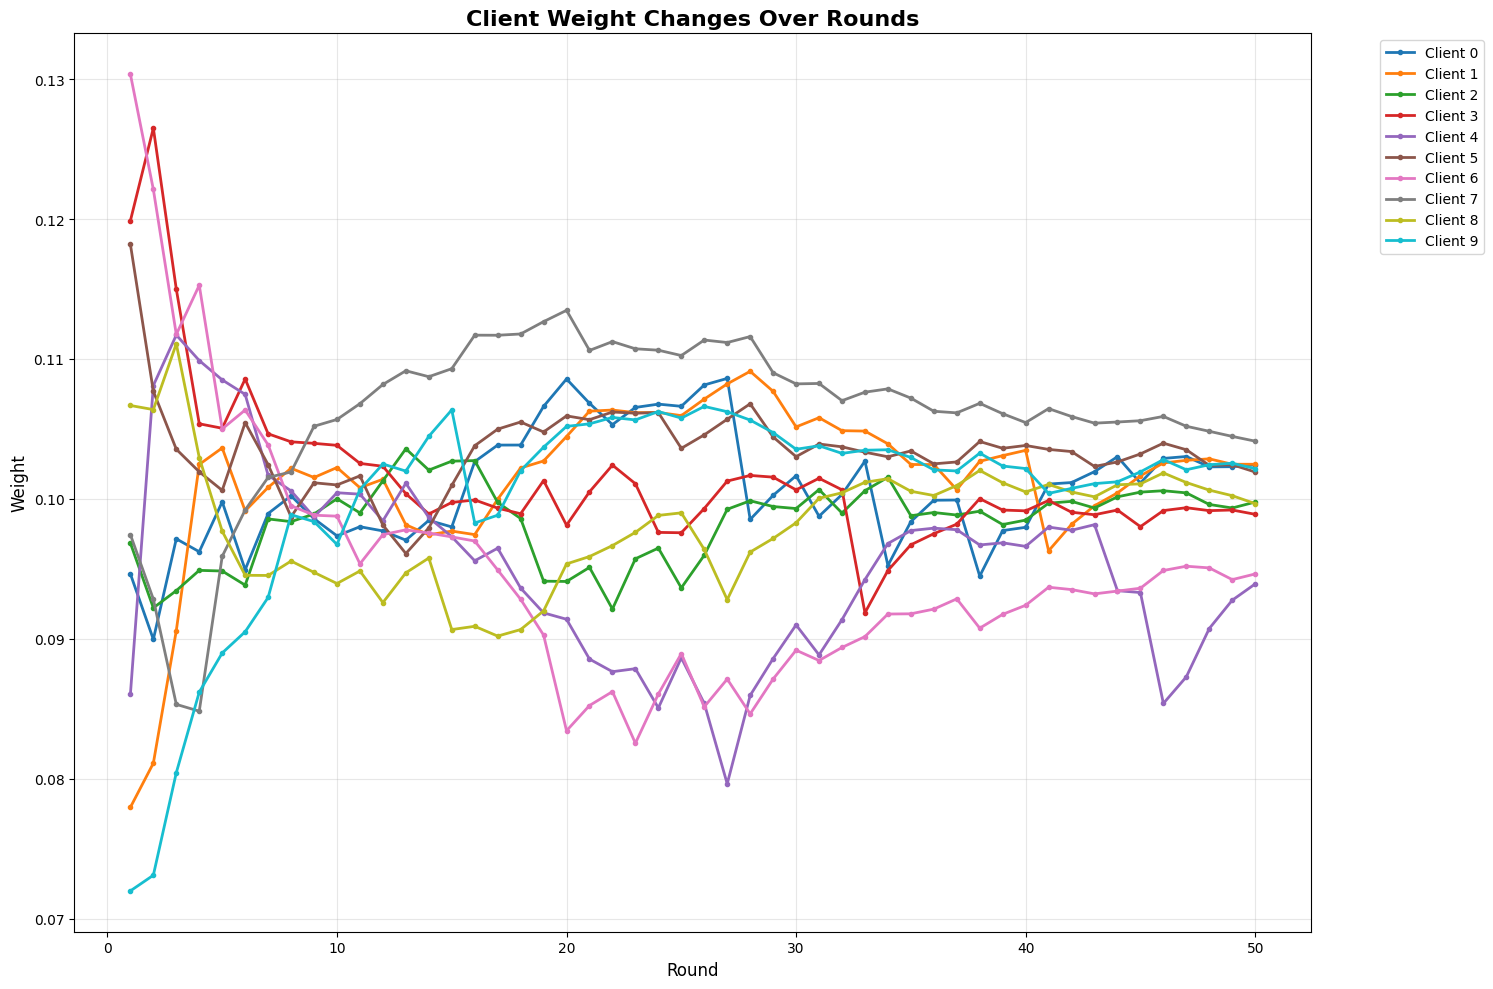

가중치 변화 분석 (초기 -> 최종):
   Client  Initial_Weight  Final_Weight  Weight_Change
0       0        0.094636      0.102436       0.007800
1       1        0.077954      0.102475       0.024521
2       2        0.096840      0.099772       0.002932
3       3        0.119879      0.098897      -0.020982
4       4        0.086034      0.093920       0.007886
5       5        0.118198      0.101920      -0.016278
6       6        0.130356      0.094633      -0.035723
7       7        0.097446      0.104126       0.006680
8       8        0.106675      0.099662      -0.007013
9       9        0.071981      0.102160       0.030179


In [17]:
# 클라이언트별 가중치 변화 추이
if not weights_df.empty:
    plt.figure(figsize=(15, 10))
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for i in range(10):
        col_name = f'Client_{i}_Weight'
        if col_name in weights_df.columns:
            plt.plot(weights_df['Round'], weights_df[col_name], 
                    marker='o', markersize=3, linewidth=2, 
                    label=f'Client {i}', color=colors[i])
    
    plt.title('Client Weight Changes Over Rounds', fontsize=16, fontweight='bold')
    plt.xlabel('Round', fontsize=12)
    plt.ylabel('Weight', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 가중치 통계 분석
    weight_cols = [f'Client_{i}_Weight' for i in range(10)]
    final_weights = weights_df[weight_cols].iloc[-1]
    initial_weights = weights_df[weight_cols].iloc[0]
    weight_change = final_weights - initial_weights
    
    print("가중치 변화 분석 (초기 -> 최종):")
    weight_analysis = pd.DataFrame({
        'Client': range(10),
        'Initial_Weight': initial_weights.values,
        'Final_Weight': final_weights.values,
        'Weight_Change': weight_change.values
    })
    print(weight_analysis.round(6))
    
else:
    print("가중치 데이터를 찾을 수 없습니다.")

In [18]:
# 가중치 분포 히트맵
if not weights_df.empty:
    weight_matrix = weights_df[weight_cols].values.T
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(weight_matrix, 
                xticklabels=weights_df['Round'].values[::5],  # 5라운드마다 표시
                yticklabels=[f'Client {i}' for i in range(10)],
                cmap='RdYlBu_r', cbar_kws={'label': 'Weight'})
    plt.title('Client Weights Heatmap Across All Rounds', fontsize=14, fontweight='bold')
    plt.xlabel('Round')
    plt.ylabel('Client')
    plt.tight_layout()
    plt.show()
    
    # 가중치 균등성 분석 (표준편차로 측정)
    weight_std_per_round = weights_df[weight_cols].std(axis=1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(weights_df['Round'], weight_std_per_round, 
             marker='o', linewidth=2, markersize=4, color='purple')
    plt.title('Weight Distribution Evenness Over Rounds\n(Lower = More Even)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Round')
    plt.ylabel('Standard Deviation of Weights')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"가중치 분포 균등성:")
    print(f"초기 라운드 표준편차: {weight_std_per_round.iloc[0]:.6f}")
    print(f"최종 라운드 표준편차: {weight_std_per_round.iloc[-1]:.6f}")
    print(f"평균 표준편차: {weight_std_per_round.mean():.6f}")

NameError: name 'sns' is not defined

<Figure size 1500x800 with 0 Axes>

## 분석 요약

### 주요 발견사항:

1. **성능 개선 패턴**: 모델은 초기 몇 라운드에서 급격한 성능 향상을 보이며, 약 20라운드 이후부터 수렴하는 패턴을 보입니다.

2. **데이터 분포**: 클라이언트 간 데이터 분포가 불균등하며, 이는 Dirichlet 분포(α=0.5)를 사용한 non-IID 설정의 결과입니다.

3. **가중치 변화**: 클라이언트별 기여도가 라운드가 진행됨에 따라 변화하며, 데이터 품질과 양에 따라 조정되는 것을 확인할 수 있습니다.

4. **수렴성**: 성능 지표들이 안정적으로 수렴하고 있으며, 추가 학습의 필요성이 낮아 보입니다.